In [1]:
import pyproj
import numpy as np
import geopandas as gpd
import pandas as pd
import math
from shapely.geometry import Polygon

In [2]:
def _box_to_gdf(minx, miny, maxx, maxy, crs='EPSG:4326'):
    miny = miny + 0.00001
    maxx = maxx - 0.00001
    geo = Polygon([(minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny)])
    return gpd.GeoDataFrame(geometry=[geo], crs=crs)

In [3]:
geometry = gpd.read_file('/home/ah2174/shapefiles/Amazon_rainforest_shapefile.zip').to_crs('EPSG:4326')

minx, miny, maxx, maxy = geometry.bounds.values[0]
minx, miny, maxx, maxy = np.floor(minx), np.floor(miny), np.ceil(maxx), np.ceil(maxy)


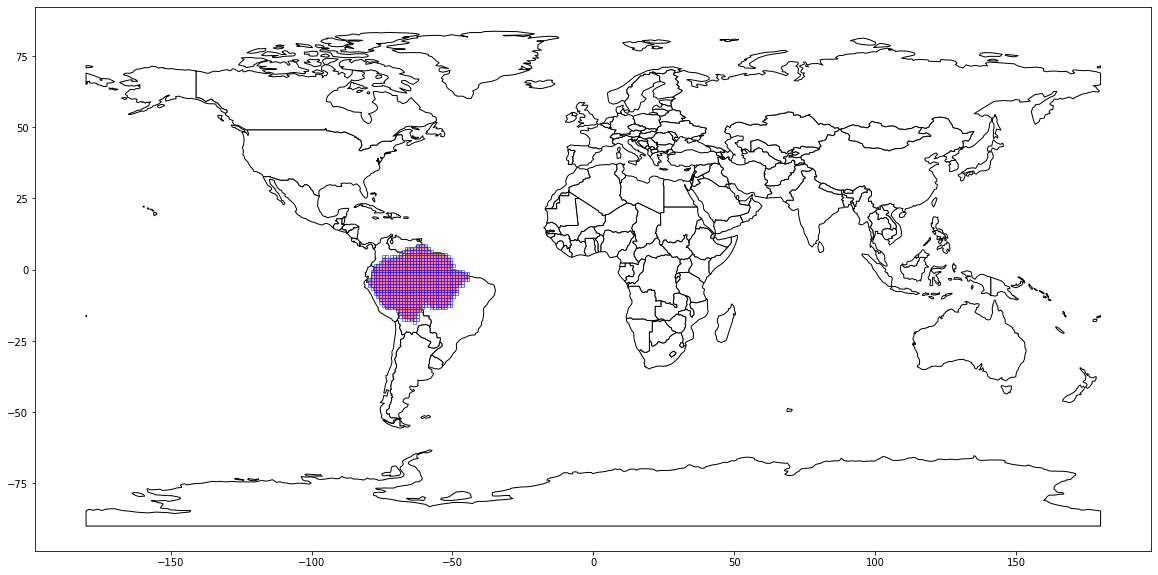

In [4]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.plot(color='white', edgecolor='black', figsize  = (20, 20))
geometry.plot(ax=base, color='white', edgecolor='green', alpha=1)

for y in range(int(miny), int(maxy)):
    for x in range(int(minx), int(maxx)):
        tile_gdf = _box_to_gdf(x, y, x + 1, y + 1)
        tile_region = geometry.overlay(tile_gdf, how="intersection")
        if tile_region.empty:
            continue
        tile_region.plot(ax=base, color='red', edgecolor=None, alpha=1)
        tile_gdf.plot(ax=base, color='white', edgecolor='blue', alpha=0.5)

<AxesSubplot:>

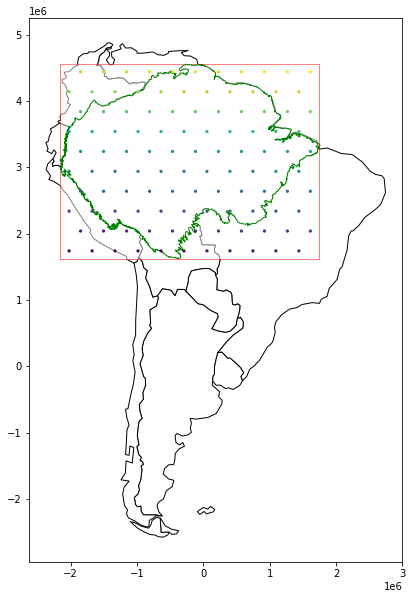

In [4]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
sa = world[world.continent == "South America"]

sa_albers = pyproj.CRS.from_string("ESRI:102033")
view_proj = sa_albers
# view_proj = pyproj.CRS.from_string("EPSG:4326")
geometry = gpd.read_file('/home/ah2174/shapefiles/Amazon_rainforest_shapefile.zip').to_crs(sa_albers)
minx, miny, maxx, maxy = geometry.bounds.values[0]
minx, miny, maxx, maxy = np.floor(minx), np.floor(miny), np.ceil(maxx), np.ceil(maxy)
box = _box_to_gdf(minx, miny, maxx, maxy, sa_albers)

diameter = 300000
dx = diameter / math.sqrt(3) * 2
dy = diameter

x = np.arange(minx, maxx - dx / 2, dx)
y = np.arange(miny, maxy, dy)

if y.shape[0] % 2 == 0:
    xs = np.tile(np.append(x, x + dx / 2), int(y.shape[0] / 2))
else:
    xs = np.append(np.tile(np.append(x, x + dx / 2), int(y.shape[0] / 2)), x + dx / 2)

ys = np.repeat(y, x.shape[0])

xs = xs + (maxx - max(xs)) / 2
ys = ys + (maxy - max(ys)) / 2

labels = np.arange(ys.shape[0])

ax = sa.to_crs(view_proj).plot(color='white', edgecolor='black', figsize  = (10, 10))
box.to_crs(view_proj).plot(ax=ax, color="white", edgecolor="red", alpha=0.5)
geometry.to_crs(view_proj).plot(ax=ax, color='white', edgecolor='green', alpha=1)
pts = gpd.GeoSeries(gpd.points_from_xy(xs, ys), crs=sa_albers)
pts.to_crs(view_proj).plot(ax=ax, c=labels, markersize=5)

In [25]:
def axial_round(qs: np.array, rs: np.array):
    """Round floating point hexagonal coordinates to integers.
    Effectively, this maps each point in hexagonal space to the canonical
    name of the grid hexagon that contains it.

    See https://observablehq.com/@jrus/hexround
    for algorithm and details.

    All coordinates are given in axial notation."""
    qgrid = np.round(qs)
    rgrid = np.round(rs)
    q_diff = qs - qgrid
    r_diff = rs - rgrid

    q_larger = np.abs(q_diff) >= np.abs(r_diff)

    qgrid[q_larger] += np.round(q_diff[q_larger] + 0.5 * r_diff[q_larger])
    rgrid[~q_larger] += np.round(r_diff[~q_larger] + 0.5 * q_diff[~q_larger])
    return qgrid.astype(int), rgrid.astype(int)

def cube_round(q: np.array, r: np.array, s:np.array):
    qgrid = np.round(q)
    rgrid = np.round(r)
    sgrid = np.round(s)

    q_diff = np.abs(qgrid - q)
    r_diff = np.abs(rgrid - r)
    s_diff = np.abs(sgrid - s)

    cond1 = np.logical_and(q_diff > r_diff, q_diff > s_diff)
    qgrid[cond1] = -rgrid[cond1]-sgrid[cond1]

    cond2 = np.logical_and(~cond1, r_diff > s_diff)
    rgrid[cond2] = -qgrid[cond2]-sgrid[cond2]

    cond3 = np.logical_and(~cond1, s_diff >= r_diff)
    sgrid[cond3] = -qgrid[cond3]-rgrid[cond3]

    return qgrid, rgrid, sgrid

def axial_to_cube(q: np.array, r:np.array):
    return q, r, -q-r

def cube_to_axial(q: np.array, r:np.array, s:np.array):
    return q, r

def xy_to_axial(xs: np.array, ys: np.array, diameter: int):
    """Convert an array of x,y points to coordinates on a hexagonal grid
    with the given hexagon diameter.
    The result will be given in axial integer coordinates.

    See https://www.redblobgames.com/grids/hexagons/#pixel-to-hex
    for algorithm and details.
    """
    # sqrt3 = math.sqrt(3)
    # ratio = np.array([2/sqrt3, math.sqrt(2/sqrt3), 1]) * diameter
    # qs_float = xs * ratio
    # rs_float = ratio * 0.5 * (sqrt3 * ys - xs)
    qs_float = (2. * xs / 3) / diameter
    rs_float = (-1. / 3 * xs + math.sqrt(3) / 3 * ys) / diameter
    return axial_round(qs_float, rs_float)
    # return(cube_to_axial(*cube_round(*axial_to_cube(qs_float, rs_float))))


def pair_to_label(xs: np.array, ys: np.array):
    """Map integer pairs to a unique integer value.

    See https://stackoverflow.com/questions/919612/
    mapping-two-integers-to-one-in-a-unique-and-deterministic-way

    for algorithm and details.
    The idea is to label each hexagon, identified by its (q,r) coords,
    with a single unique id number.
    """
    x = np.copy(xs)
    y = np.copy(ys)
    labels = np.zeros(x.shape)
    x[x >= 0] = 2 * x[x >= 0]
    x[x < 0] = -2 * x[x < 0] - 1

    y[y >= 0] = 2 * y[y >= 0]
    y[y < 0] = -2 * y[y < 0] - 1

    x_larger = x >= y
    labels[x_larger] = x[x_larger] * x[x_larger] + x[x_larger] + y[x_larger]
    labels[~x_larger] = x[~x_larger] + y[~x_larger] * y[~x_larger]
    return labels

114954
[-65 -64 -63 -62 -61 -60 -59 -58 -57 -56 -55 -54 -53 -52 -51 -50 -49 -48
 -47 -46 -45 -44 -43 -42 -41 -40 -39 -38 -37 -36 -35 -34 -33 -32 -31 -30
 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12
 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6
   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24
  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42
  43  44  45  46  47  48  49  50  51  52  53]
[ 16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33
  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 14

<AxesSubplot:>

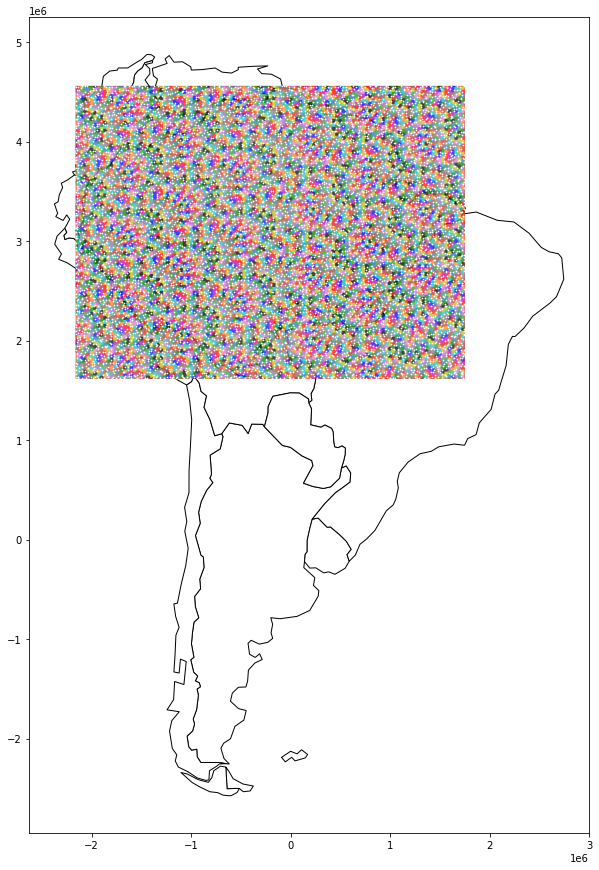

In [42]:
# Visualization:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
sa = world[world.continent == "South America"]
sa_albers = pyproj.CRS.from_string("ESRI:102033")
view_proj = sa_albers
#view_proj = pyproj.CRS.from_string("EPSG:4326")

geometry = gpd.read_file('/home/ah2174/shapefiles/Amazon_rainforest_shapefile.zip').to_crs(sa_albers)
minx, miny, maxx, maxy = geometry.bounds.values[0]
minx, miny, maxx, maxy = np.floor(minx), np.floor(miny), np.ceil(maxx), np.ceil(maxy)
box = _box_to_gdf(minx, miny, maxx, maxy, sa_albers)
# Create a grid of points that fills up the bounding box
# When labeled with their enclosing hexagon and plotted with color-by-label,
# we expect to see a hexagonal tesselation show up
step = 10000
x = np.arange(minx, maxx, step)
y = np.arange(miny, maxy, step)
xs, ys = np.meshgrid(x, y)
xs = xs.flatten()
print(len(xs))
ys = ys.flatten()

# Convert to hex-coordinates and label
diameter = 22200
qs, rs = xy_to_axial(xs, ys, diameter)

# Create a unique label for each q, r hex coordinate
labels = pair_to_label(qs, rs)
print(np.unique(qs))
print(np.unique(rs))
# drop every other hexagon to ensure points are *at least* diameter apart
# (mean 2 x diameter apart)
# labels[np.mod(qs, 2) == 0] = 0
# labels[np.mod(rs, 2) == 0] = 0

# colormap
color_list = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','r','y','m','k','b','g','c']
colors = [color_list[i] for i in list(np.mod(labels.astype(int), len(color_list)))]
# for i in range(len(labels)):
#     if labels[i] == 0:
#         colors[i] = 'w'

# colors = ['r' if qs[i] == 1 or rs[i] == 5 else 'b' for i in range(len(qs))]

# Randomly sample one point from each hexagon
pts = gpd.GeoDataFrame({'labels': labels, 'colors': colors}, geometry=gpd.points_from_xy(xs, ys), crs=sa_albers)
rng = np.random.default_rng()
sample = gpd.GeoDataFrame(pts.groupby('labels').agg(rng.choice), crs=sa_albers)

ax = sa.to_crs(view_proj).plot(color='white', edgecolor='black', figsize  = (15,15))
box.to_crs(view_proj).plot(ax=ax, color="white", edgecolor="red", alpha=0.5)
geometry.to_crs(view_proj).plot(ax=ax, color='white', edgecolor='green', alpha=1)
pts.to_crs(view_proj).plot(ax=ax, c=pts.colors, markersize=0.1)
sample.to_crs(view_proj).plot(ax=ax, c='w', markersize=0.5)



In [96]:
sample_shots = pd.read_feather('/maps/forecol/data/Overlays/gedi_jrc_newdata_spark.feather')
print(sample_shots)


                shot_number  recovery_period  overlap_quality  lon_lowestmode  \
0         35990800100077292             13.0                0      -63.728743   
1         35990800100077291             13.0                0      -63.729074   
2         25690000400287691              5.0                2      -65.126884   
3         33091100100051698             33.0                0      -65.141602   
4         29120300100051735              3.0                0      -65.102402   
...                     ...              ...              ...             ...   
2631767  131090000300483690           2021.0                0      -59.593181   
2631768  131090300300484084              7.0                0      -59.501721   
2631769  131091100300483310           2021.0                0      -59.656027   
2631770  131091100300483311           2021.0                0      -59.655724   
2631771  142460500200090024              5.0                0      -59.497317   

         lat_lowestmode    

In [ ]:
# Random spatial sampling: minimal code

# 0. Get some points
from src.data.gedi_database import GediDatabase
db = GediDatabase()
pts = db.query(table_name='level_4a', columns='shot_number', geometry=gpd.GeoSeries(box(-60, 0, -59.995, 0.005)), use_geopandas=True)

# 1. Label the points with the hexagon that contains them
diameter = 4000 # 4 km
sa_albers = pyproj.CRS.from_string("ESRI:102033")
pts = pts.to_crs(sa_albers)
pts['label'] = pair_to_label(*xy_to_axial(pts.geometry.x, pts.geometry.y, diameter=diameter))

# 2. Group the points by hexagon and pick one random point from each hexagon
rng = np.random.default_rng()
pts.groupby('label').agg(rng.choice)